In [1]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 49.0 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import classification_report
from gensim.models import Word2Vec
import underthesea as uts
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vne_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/vneconomy_articles_23_1nam.csv", encoding='utf8', engine='python').dropna()
vs_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/vietstock_articles_23_2thang.csv", encoding='utf8', engine='python').dropna()
label1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/labeled_sentences_1.csv", encoding='utf8', engine='python').dropna()
label2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/labeled_sentences_2.csv", encoding='utf8', engine='python').dropna()
label3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/labeled_sentences_3.csv", encoding='utf8', engine='python').dropna()
merge_label = pd.concat([label1, label2, label3]).reset_index(drop=True)

# Labeled data insight

In [ ]:
merge_label['Sentences']

0       Trên thị trường chứng khoán, chốt phiên ngày 3...
1       Nhóm cổ phiếu bất động sản tăng mạnh, có dòng ...
2        Top 10 cổ phiếu lớn nhất trong danh mục hiện ...
3        Cụ thể, giá thép ước tính tăng 10% so với Q4/...
4        Một số khác đề cập đến việc lợi suất trái phi...
                              ...                        
2994     Quan điểm mà Fed đưa ra vẫn là sẽ hành động t...
2995    Sở Giao dịch Chứng khoán Hà Nội (HNX) vừa cho ...
2996     Lợi nhuận sau thuế tăng vọt 163,4% theo năm -...
2997    Đồng thời, cũng trong quý 1/2023, công ty thôn...
2998    Để đảm bảo thông tin đầy đủ đén nhà đầu tư, HO...
Name: Sentences, Length: 2999, dtype: object

In [ ]:
txt = ''
for s in merge_label['Sentences']:
    txt += s
words = uts.word_tokenize(txt)

In [ ]:
clean_words = [re.sub('[^\w\s]', '', word) for word in words]
clean_words = [re.sub('\d', '', word) for word in clean_words]
clean_words = [word for word in clean_words if word.strip()]

In [ ]:
fd = nltk.FreqDist(clean_words)
common_words = fd.most_common(20)

Text(0.5, 1.0, 'Tần suất xuất hiện của các từ trong tập dữ liệu đã gán nhãn')

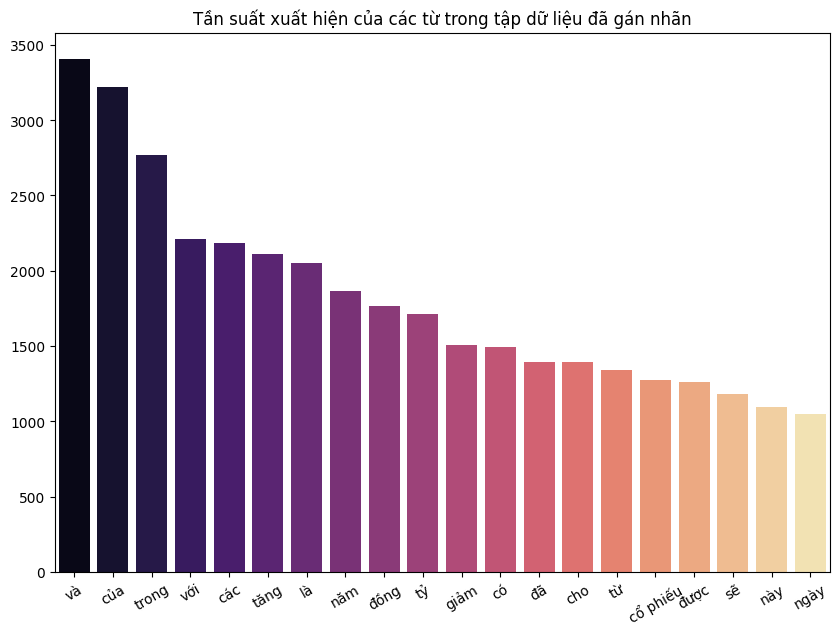

In [ ]:
all_fdist = common_words
all_fdist = pd.Series(dict(all_fdist))
fig, ax = plt.subplots(figsize=(10,7))
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, palette='magma', ax=ax)
plt.xticks(rotation=30)
plt.title('Tần suất xuất hiện của các từ trong tập dữ liệu đã gán nhãn')

In [ ]:
sentiment_data = merge_label['Sentiment'].value_counts().to_dict()
list(sentiment_data.values())

[1197, 919, 883]

Text(0.5, 1.0, 'Tần suất câu mang tính')

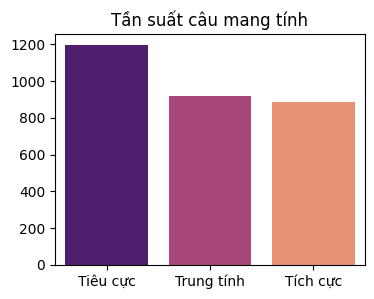

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
lg = ["Tiêu cực","Trung tính","Tích cực"]
all_plot = sns.barplot(x=lg, y=list(sentiment_data.values()), palette='magma', ax=ax)
plt.title('Tần suất câu mang tính')

# Model

In [ ]:
train, test = train_test_split(merge_label, test_size=0.3, shuffle=True)

## SVM with TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = uts.word_tokenize,
                             min_df = 0.01,
                             max_df = 0.7,
                             sublinear_tf = True,
                             use_idf = True)

In [ ]:
train_vectors = vectorizer.fit_transform(train['Sentences']).toarray()
test_vectors = vectorizer.transform(test['Sentences']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Perform classification with SVM
svm_classifier = svm.SVC(kernel='poly', degree=1)
svm_classifier.fit(train_vectors, train['Sentiment'])
svm_prediction = svm_classifier.predict(test_vectors)
report_svm = classification_report(test['Sentiment'], svm_prediction, output_dict=True)
print('positive: ', report_svm['1.0'])
print('negative: ', report_svm['-1.0'])
print('neutral: ', report_svm['0.0'])
#SVM

positive:  {'precision': 0.5229007633587787, 'recall': 0.4910394265232975, 'f1-score': 0.5064695009242145, 'support': 279}
negative:  {'precision': 0.4959677419354839, 'recall': 0.484251968503937, 'f1-score': 0.49003984063745026, 'support': 254}
neutral:  {'precision': 0.5769230769230769, 'recall': 0.6130790190735694, 'f1-score': 0.59445178335535, 'support': 367}


In [ ]:
#Test
review = "Chứng khoán ngày hôm qua biến động, tăng mạnh mẽ."
review_vector = vectorizer.transform([review]).toarray()
print(svm_classifier.predict(review_vector))

[1.]


## SVM with Word2Vec

In [ ]:
train_sentences = train['Sentences'].apply(uts.word_tokenize)
test_sentences = test['Sentences'].apply(uts.word_tokenize)

In [ ]:
w2v_model = Word2Vec(train_sentences, min_count=1, window=5)

In [ ]:
# Function to convert sentences to their vector representations
def sentence_to_vec(sentence, model):
    return np.mean([model.wv[word] for word in sentence if word in model.wv], axis=0)

In [ ]:
train_vectors = train_sentences.apply(lambda x: sentence_to_vec(x, w2v_model))
test_vectors = test_sentences.apply(lambda x: sentence_to_vec(x, w2v_model))

In [ ]:
svm_classifier = svm.SVC(kernel='poly', degree=1)
svm_classifier.fit(np.vstack(train_vectors.values), train['Sentiment'])
svm_prediction = svm_classifier.predict(np.vstack(test_vectors.values))
report_svm = classification_report(test['Sentiment'], svm_prediction, output_dict=True)
print('positive: ', report_svm['1.0'])
print('negative: ', report_svm['-1.0'])
print('neutral: ', report_svm['0.0'])

positive:  {'precision': 0.38961038961038963, 'recall': 0.43010752688172044, 'f1-score': 0.40885860306643956, 'support': 279}
negative:  {'precision': 0.19047619047619047, 'recall': 0.031496062992125984, 'f1-score': 0.05405405405405405, 'support': 254}
neutral:  {'precision': 0.5, 'recall': 0.7493188010899182, 'f1-score': 0.5997818974918212, 'support': 367}


In [ ]:
#Test
review = "Chứng khoán ngày hôm qua biến động, tăng mạnh mẽ."
review_sentence = uts.word_tokenize(review)
review_vector = sentence_to_vec(review_sentence, w2v_model)
review_vector = np.array(review_vector).reshape(1, -1)
svm_prediction = svm_classifier.predict(review_vector)
print(svm_prediction)


[1.]


## Vanilla Neural Network

In [ ]:
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=150, batch_size=10)